# Libraries and functions

In [1]:
import helper
from helper import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from skopt import gp_minimize

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

%matplotlib inline

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.
/home/rneves/anaconda3/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [71]:
def print_results(model, df_train, df_test, train_x, test_x, keras=True):
    """
    Print results of model. MSE and competetion score
    """

    if keras:
        predictions = model.predict(test_x, batch_size = batch_size)
        predictions_train = model.predict(train_x, batch_size = batch_size)
    else:
        predictions = model.predict(test_x)
        predictions_train = model.predict(train_x)
    
    df_train.reset_index(inplace=True)
    df_test.reset_index(inplace=True)
    
    df_predictions = df_test.join(pd.DataFrame(predictions.round()))
    df_predictions_train = df_train.join(pd.DataFrame(predictions_train.round()))
    
    df_predictions.rename(columns={0: 'Prediction'}, inplace=True)
    df_predictions_train.rename(columns={0: 'Prediction'}, inplace=True)
    
    df_predictions['error'] = df_predictions.apply(lambda df: error_function(df), axis=1)
    df_predictions_train['error'] = df_predictions_train.apply(lambda df: error_function(df), axis=1)

    df_predictions['score'] = df_predictions.apply(lambda df: score_function(df), axis=1)
    df_predictions_train['score'] = df_predictions_train.apply(lambda df: score_function(df), axis=1)

    MSE_all = mean_squared_error(df_predictions['RUL'], df_predictions['Prediction'])
    MSE_train_all = mean_squared_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])
    
    print('{:.2f}'.format(MSE_all))
    print('{:.2f}'.format(MSE_train_all))
    
    MAE_all = mean_absolute_error(df_predictions['RUL'], df_predictions['Prediction'])
    MAE_train_all = mean_absolute_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])
    
    print('{:.2f}'.format(MAE_all))
    print('{:.2f}'.format(MAE_train_all))

    ##################
    
    temp_df = pd.DataFrame(df_predictions.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
    df_target = pd.merge(temp_df, df_predictions, how='left', on=('dataset_id', 'unit_id', 'cycle'))

    temp_df = pd.DataFrame(df_predictions_train.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
    df_target_train = pd.merge(temp_df, df_predictions_train, how='left', on=('dataset_id', 'unit_id', 'cycle'))
    
    MSE = mean_squared_error(df_target['RUL'], df_target['Prediction'])
    MSE_train = mean_squared_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MSE))
    print('{:.2f}'.format(MSE_train))
    
    MAE = mean_absolute_error(df_target['RUL'], df_target['Prediction'])
    MAE_train = mean_absolute_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MAE))
    print('{:.2f}'.format(MAE_train))
    
    score_test = df_target['score'].sum()
    score_train = df_target_train['score'].sum()

    print('{:.2f}'.format(score_test))
    print('{:.2f}'.format(score_train))
    
    return df_predictions, df_predictions_train, df_target, df_target_train

def print_results_all(df_predictions, df_predictions_train, df_target, df_target_train):

    MSE_all = mean_squared_error(df_predictions['RUL'], df_predictions['Prediction'])
    MSE_train_all = mean_squared_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])
    
    print('{:.2f}'.format(MSE_all))
    print('{:.2f}'.format(MSE_train_all))
    
    MAE_all = mean_absolute_error(df_predictions['RUL'], df_predictions['Prediction'])
    MAE_train_all = mean_absolute_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])
    
    print('{:.2f}'.format(MAE_all))
    print('{:.2f}'.format(MAE_train_all))

    ##################
    
    MSE = mean_squared_error(df_target['RUL'], df_target['Prediction'])
    MSE_train = mean_squared_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MSE))
    print('{:.2f}'.format(MSE_train))
    
    MAE = mean_absolute_error(df_target['RUL'], df_target['Prediction'])
    MAE_train = mean_absolute_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MAE))
    print('{:.2f}'.format(MAE_train))
    
    score_test = df_target['score'].sum()
    score_train = df_target_train['score'].sum()

    print('{:.2f}'.format(score_test))
    print('{:.2f}'.format(score_train))

# Load data

In [222]:
datasets = []

RUL_BY_PART = True

path = '/home/rneves/thesis/Turbofan_Engine/' # path to numpy arrays to plot t-sne

df_train = pd.read_pickle(path + 'dataframes/df_separated_train')
df_test = pd.read_pickle(path + 'dataframes/df_separated_test')

if RUL_BY_PART:
    df_train['RUL'] = df_train.apply(lambda r: RUL_by_parts(r), axis=1)
    df_test['RUL'] = df_test.apply(lambda r: RUL_by_parts(r), axis=1)

df_train.sort_values(by=['dataset_id', 'unit_id', 'cycle'], inplace=True)
df_test.sort_values(by=['dataset_id', 'unit_id', 'cycle'], inplace=True)

df_train.reset_index(drop = True, inplace=True)
df_test.reset_index(drop = True, inplace=True)

df_train, df_test = cat_to_continuous_Encoder(df_train, df_test)
#df_train, df_test = cat_to_continuous_Binarizer(df_train, df_test)

df_train.drop((['index']), axis=1, inplace=True)
df_test.drop((['index']), axis=1, inplace=True)

train_x = df_train.drop((['setting 1', 'setting 2', 'setting 3','dataset_id', 'RUL', 'unit_id', 'HDBScan', 'index_diff']), axis=1)
train_y = df_train['RUL'].copy()

test_x = df_test.drop((['setting 1', 'setting 2', 'setting 3','dataset_id', 'RUL', 'unit_id', 'HDBScan', 'index_diff']), axis=1)
test_y = df_test['RUL'].copy()

# Choose Features and Dataset ID

In [253]:
number = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
length = [5, 10, 15]

sensor_columns = ["sensor {}".format(s) for s in number]
sensor_columns_rolling_mean = ["sensor {}_rolling_mean_{}".format(x, s) for s in length for x in number]
sensor_columns_rolling_std = ["sensor {}_rolling_std_{}".format(x, s) for s in length for x in number]
sensor_columns_rolling_min = ["sensor {}_rolling_min_{}".format(x, s) for s in length for x in number]
sensor_columns_rolling_max = ["sensor {}_rolling_max_{}".format(x, s) for s in length for x in number]
sensor_columns_rolling_median = ["sensor {}_rolling_median_{}".format(x, s) for s in length for x in number]


sensor_columns_diff = ["sensor {}_diff".format(s) for s in number]
sensor_columns_rolling_mean_diff = ["sensor {}_rolling_mean_{}_diff".format(x, s) for s in length for x in number]
sensor_columns_rolling_std_diff = ["sensor {}_rolling_std_{}_diff".format(x, s) for s in length for x in number]
sensor_columns_rolling_min_diff = ["sensor {}_rolling_min_{}_diff".format(x, s) for s in length for x in number]
sensor_columns_rolling_max_diff = ["sensor {}_rolling_max_{}_diff".format(x, s) for s in length for x in number]
sensor_columns_rolling_median_diff = ["sensor {}_rolling_median_{}_diff".format(x, s) for s in length for x in number]

columns_to_plot = sensor_columns + sensor_columns_diff

columns_to_plot = list(np.append(columns_to_plot, ['setting_op_one_hot']))

# xGBoost

In [ ]:
def get_model(params):
    n_estimators, max_depth, subsample, colsample_bytree, scale_pos_weight, min_child_weight, gamma, lr, reg_alpha, reg_lambda = params

    # Set up classifier
    model = XGBRegressor(    
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            objective="reg:linear",
                            learning_rate=lr, 
                            subsample=subsample,
                            min_child_weight=min_child_weight,
                            colsample_bytree=colsample_bytree,
                            scale_pos_weight=scale_pos_weight,
                            gamma=gamma,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            nthread=NJOBS,
                            seed=SEED,
                        )
    return model

def objective(params):
    try:
        # Run CV
        model = get_model(params)
        scores = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=5) #"""scoring=evaluation_score"""
        return -scores.mean()
    
    except: return 1000000.0

def xg_boost(space, initial_point, train_x, train_y, SEED, NCALLS, NJOBS, dataset_id):
    
    res_gp = gp_minimize(objective, 
                     space,
                     x0=initial_point,
                     n_calls=NCALLS, 
                     random_state=SEED, 
                     verbose=True)
    
    print("""Best parameters for dataset_id %s:
            - n_estimators=%d
            - max_depth=%d
            - subsample=%.6f
            - colsample_bytree=%.6f
            - scale_pos_weight=%.6f
            - min_child_weight=%s
            - gamma=%.6f
            - lr=%.6f
            - reg_alpha=%.6f
            - reg_lambda=%.6f""" % (dataset_id,
                                    res_gp.x[0], 
                                    res_gp.x[1], 
                                    res_gp.x[2], 
                                    res_gp.x[3],
                                    res_gp.x[4],
                                    res_gp.x[5],
                                    res_gp.x[6],
                                    res_gp.x[7],
                                    res_gp.x[8],
                                    res_gp.x[9]))

    
    model = get_model(res_gp.x)
    
    model_XGBoost = model.fit(train_x, train_y)
    
    return model_XGBoost, res_gp.x

NJOBS=6
SEED=1337
NCALLS=300

space  = [(75, 300),                         # n_estimators
          (5, 15),                          # max_depth
          (0.0, 1),                        # subsample
          (0.0, 1),                        # colsample_bytree
          (0.1, 10.0),                       # scale_pos_weight
          (0.1, 10.0),                       # min_child_weight
          (0.1, 10.0),                       # gamma
          (10**-2, 2**-1, "log-uniform"),   # lr
          (0.1, 10.0),                       # reg_alpha
          (0.1, 10.0),                       # reg_lambda
          ]                      

initial_point = [113,                       # n_estimators
                  8,                       # max_depth
                  0.729267671198,                       # subsample
                  0.599508981537,                # colsample_bytree
                  3.39827246363,                # scale_pos_weight
                  8.87761486366,          # min_child_weight
                  8.1073734431,                     # gamma
                  0.0460924387993,                     # lr
                  5.71857787402,                      # reg_alpha
                  4.4495547509,                # reg_lambda
                ]

xgboost_models = []
xgboost_results = []
xgboost_importance = []

for df in df_train.groupby('dataset_id'):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    model, results = xg_boost(space, initial_point, train_x, train_y, SEED, NCALLS, NJOBS, df[0])
    
    xgboost_models.append(model)
    xgboost_results.append(results)
    
    importance = model.booster().get_score(importance_type='weight')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    xgboost_importance.append(df)

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 4.4032
Function value obtained: 579.6746
Current minimum: 579.6746
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.8857
Function value obtained: 1331.5627
Current minimum: 579.6746
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.8984
Function value obtained: 605.0951
Current minimum: 579.6746
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.8636
Function value obtained: 585.4616
Current minimum: 579.6746
Iteration No: 5 started. Evaluating function at random point.


/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


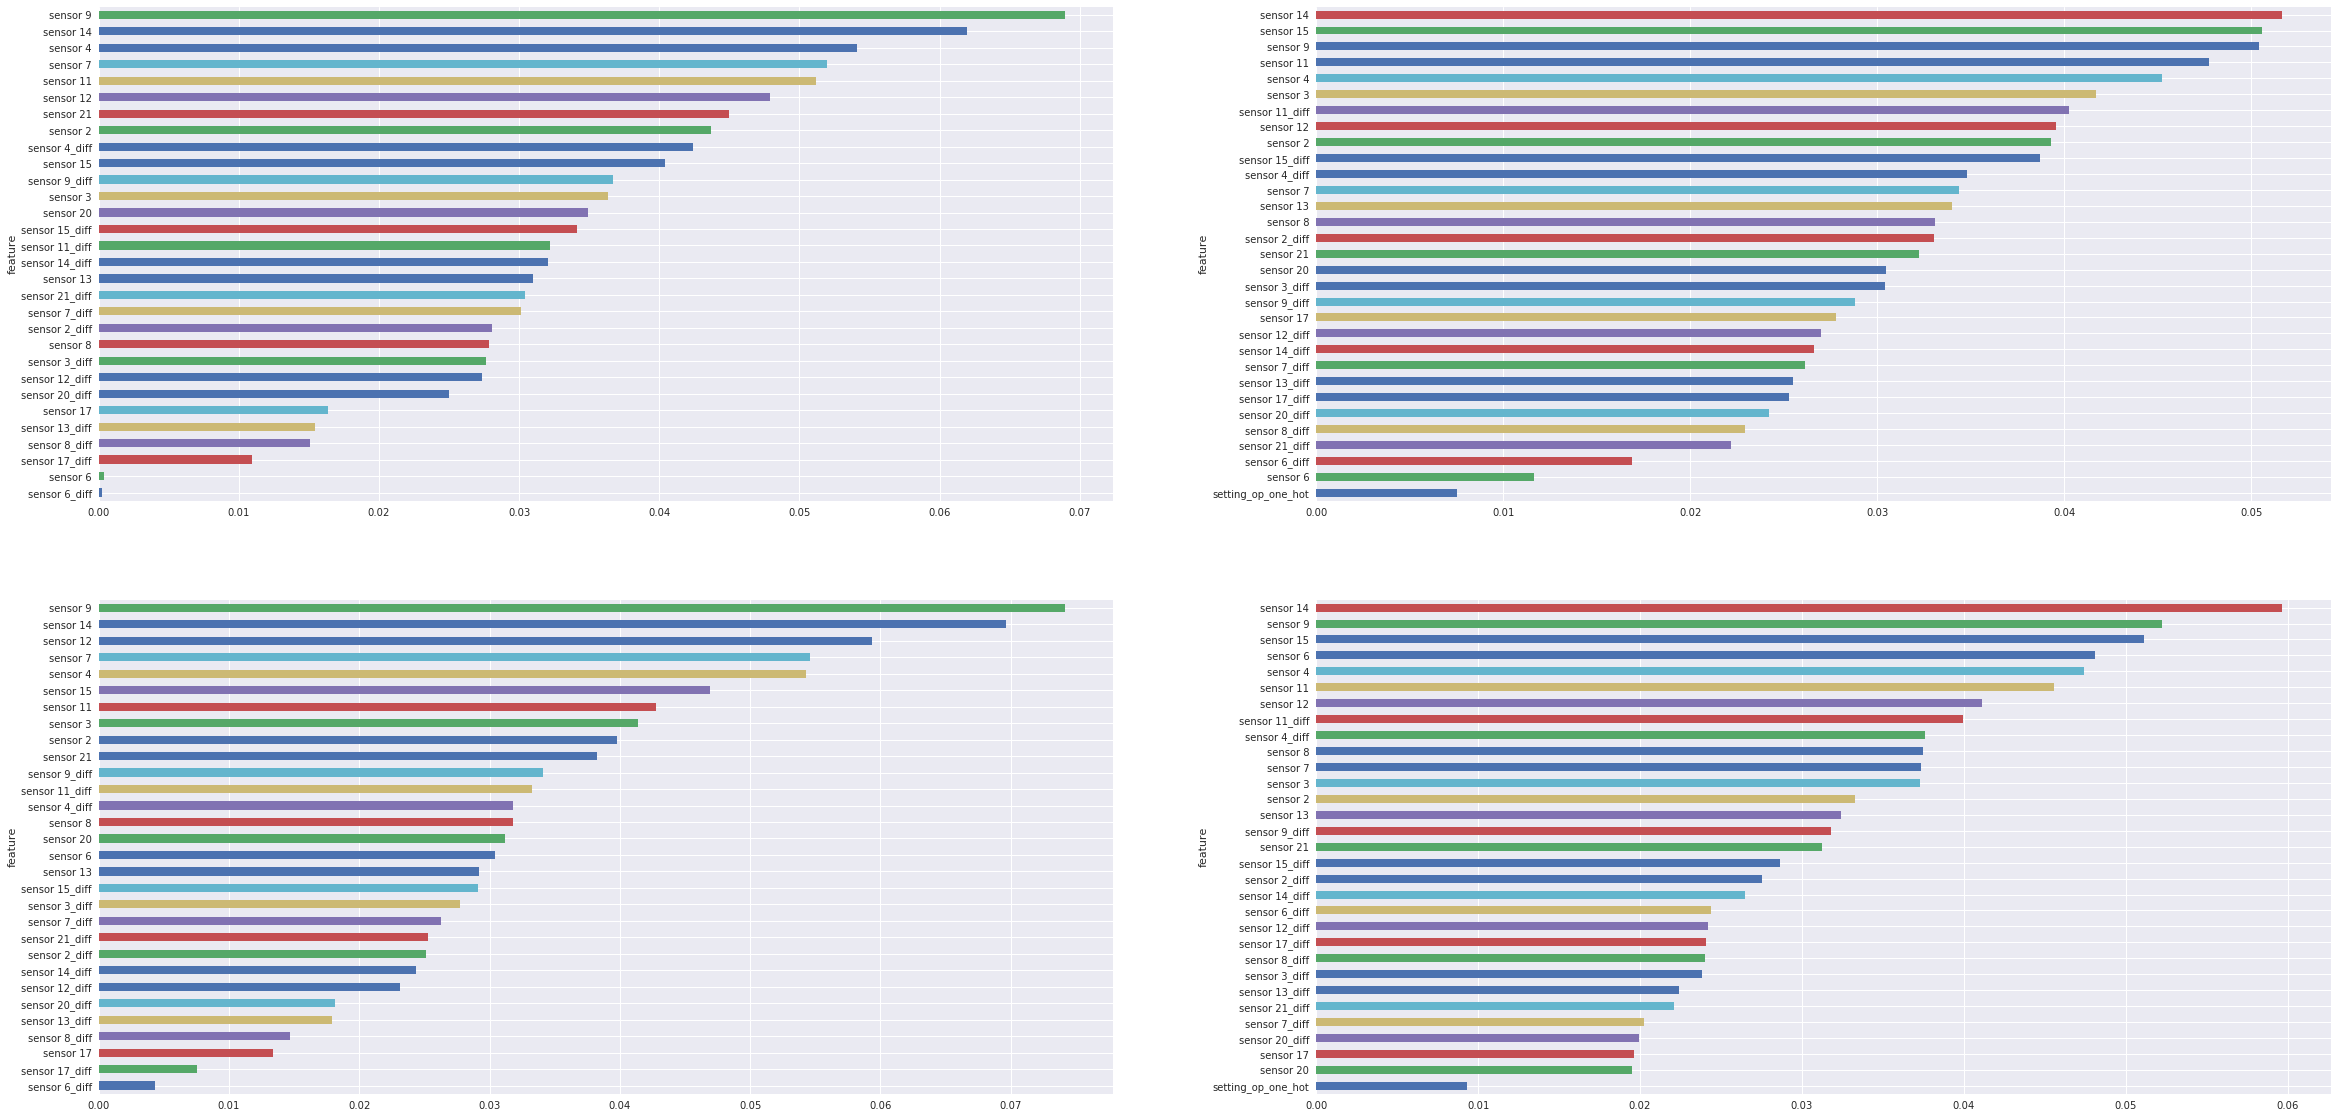

In [208]:
plt.figure(figsize=(40,20), facecolor='white')
for i, importance in enumerate(xgboost_importance):
    ax = plt.subplot(2,2,i+1)
    importance.plot(kind='barh', x='feature', y='fscore', legend=False, ax = ax)

In [209]:
predictions = []
predictions_train = []
target = []
target_train = []

for df, model in zip(df_train.groupby('dataset_id'), xgboost_models):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    df_1, df_2, df_3, df_4 = print_results(model,
                                         df_train_temp,
                                         df_test_temp,
                                         train_x,
                                         test_x,
                                         keras=False)
    predictions.append(df_1)
    predictions_train.append(df_2)
    target.append(df_3)
    target_train.append(df_4)

df_predictions = pd.concat(predictions, ignore_index=True)
df_predictions_train = pd.concat(predictions_train, ignore_index=True)
df_target = pd.concat(target, ignore_index=True)
df_target_train = pd.concat(target_train, ignore_index=True)

df_predictions.reset_index(inplace=True)
df_predictions_train.reset_index(inplace=True)
df_target.reset_index(inplace=True)
df_target_train.reset_index(inplace=True)

550.90
411.63
18.17
15.31
469.29
10.80
15.25
2.82
971.81
25.33
638.41
416.84
20.32
15.54
497.20
9.95
16.81
2.65
3368.53
61.87
412.67
316.60
14.71
12.84
617.61
6.36
18.27
2.20
1594.89
18.98
497.68
381.89
16.12
14.10
609.36
20.47
18.79
3.47
5887.13
86.31


In [210]:
print_results_all(df_predictions, df_predictions_train, df_target, df_target_train)

536.48
387.37
17.51
14.54
549.63
13.26
17.49
2.90
11822.36
192.48


# LSTM

In [83]:
def model_LSTM(train_x, train_y, test_x, test_y, batch_size, epochs, shape):

    model_LSTM = Sequential()
    model_LSTM.add(LSTM(16, input_shape=(1, shape), return_sequences=True))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(16, return_sequences=False))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(5, activation='relu'))
    model_LSTM.add(BatchNormalization())
    model_LSTM.add(Dense(1, activation='relu'))

    opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

    model_LSTM.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

    history = model_LSTM.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), shuffle=True)
    
    return model_LSTM, history

LSTM_models = []
LSTM_history = []

for df in df_train.groupby('dataset_id'):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    shape = train_x.shape[1]

    train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])
    train_y = train_y.values.reshape(train_y.shape[0], 1)

    test_x = test_x.values.reshape(test_x.shape[0], 1, test_x.shape[1])
    test_y = test_y.values.reshape(test_y.shape[0], 1)

    
    batch_size = 256
    epochs=3
    
    model, history = model_LSTM(train_x, train_y, test_x, test_y, batch_size, epochs, shape)
    
    LSTM_models.append(model)
    LSTM_history.append(history)


Train on 20631 samples, validate on 13096 samples
Epoch 1/3
20631/20631 [==============================] - 3s 123us/step - loss: 10852.9834 - mean_absolute_error: 92.3430 - val_loss: 14212.9520 - val_mean_absolute_error: 113.9898
Epoch 2/3
20631/20631 [==============================] - 1s 53us/step - loss: 9295.3803 - mean_absolute_error: 85.6266 - val_loss: 12357.1627 - val_mean_absolute_error: 106.1607
Epoch 3/3
20631/20631 [==============================] - 1s 54us/step - loss: 7784.6920 - mean_absolute_error: 78.4320 - val_loss: 10968.1772 - val_mean_absolute_error: 99.9553
Train on 53759 samples, validate on 33991 samples
Epoch 1/3
53759/53759 [==============================] - 5s 84us/step - loss: 9182.6994 - mean_absolute_error: 84.8470 - val_loss: 10508.6885 - val_mean_absolute_error: 97.4009
Epoch 2/3
53759/53759 [==============================] - 3s 52us/step - loss: 5762.0702 - mean_absolute_error: 66.8087 - val_loss: 7727.3249 - val_mean_absolute_error: 83.1210
Epoch 3/3
53

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


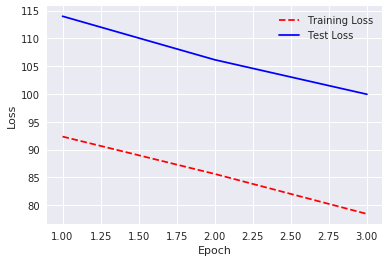

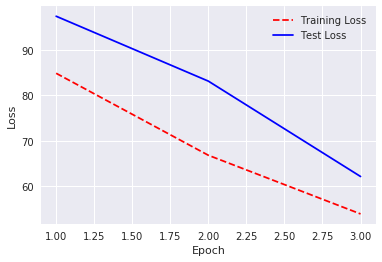

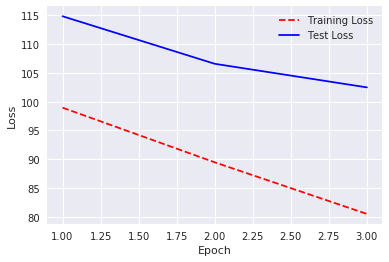

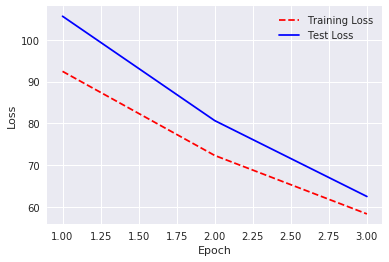

In [212]:
for history in LSTM_history:
    # Get training and test loss histories
    training_loss = history.history['mean_absolute_error']
    test_loss = history.history['val_mean_absolute_error']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [86]:
predictions = []
predictions_train = []
target = []
target_train = []

for df, model in zip(df_train.groupby('dataset_id'), LSTM_models):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])
    train_y = train_y.values.reshape(train_y.shape[0], 1)

    test_x = test_x.values.reshape(test_x.shape[0], 1, test_x.shape[1])
    test_y = test_y.values.reshape(test_y.shape[0], 1)
    
    df_1, df_2, df_3, df_4 = print_results(model,
                                         df_train_temp,
                                         df_test_temp,
                                         train_x,
                                         test_x,
                                         keras=True)
    predictions.append(df_1)
    predictions_train.append(df_2)
    target.append(df_3)
    target_train.append(df_4)

df_predictions = pd.concat(predictions, ignore_index=True)
df_predictions_train = pd.concat(predictions_train, ignore_index=True)
df_target = pd.concat(target, ignore_index=True)
df_target_train = pd.concat(target_train, ignore_index=True)

df_predictions.reset_index(inplace=True)
df_predictions_train.reset_index(inplace=True)
df_target.reset_index(inplace=True)
df_target_train.reset_index(inplace=True)

10971.93
7921.87
99.97
78.96
4871.29
0.00
61.91
0.00
1089471.23
0.00
4474.87
3165.20
62.14
48.49
2371.63
0.00
40.71
0.00
266702.79
0.00
11284.31
8756.01
102.48
84.74
4634.62
0.00
60.12
0.00
1056432.21
0.00
4398.76
3439.81
62.55
52.25
2624.58
0.00
43.13
0.00
863509.73
0.00


In [87]:
print_results_all(df_predictions, df_predictions_train, df_target, df_target_train)

6333.44
4743.90
73.40
59.44
3134.00
0.00
47.30
0.00
3276115.96
0.00


# LSTM - With Time Dependecy

## All sequence

In [78]:
array_train = []
array_train_label = []

for x in df_train.groupby(['dataset_id', 'unit_id']).groups:
    df = (df_train.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
    train = df[columns_to_plot].copy()
    label_train = df['RUL'].copy()
    array_train_label.append(label_train)
    array_train.append(train.values)

array_test = []
array_test_label = []


for x in df_test.groupby(['dataset_id', 'unit_id']).groups:
    df = (df_test.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
    test = df[columns_to_plot].copy()
    label_test = df['RUL'].copy()
    array_test_label.append(label_test)
    array_test.append(test.values)


In [79]:
train_X = np.array(array_train)
test_X = np.array(array_test)

train_Y = np.array(array_train_label)
test_Y = np.array(array_test_label)

In [80]:
model_LSTM_Time = Sequential()
model_LSTM_Time.add(LSTM(32, batch_input_shape=(1, None, train_X[1].shape[1]), return_sequences=True, stateful=False))
model_LSTM_Time.add(Dropout(0.2))
model_LSTM_Time.add(LSTM(16, return_sequences=True, stateful=False))
#model_LSTM_Time.add(Dense(100, activation='relu'))
model_LSTM_Time.add(Dropout(0.2))
model_LSTM_Time.add(TimeDistributed(Dense(1, activation='relu')))

model_LSTM_Time.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

#model_LSTM_Time.fit(train_X, train_Y, epochs=5, validation_data=(test_X, test_Y), shuffle=True)

In [ ]:
predictions_ = []
predictions_train_ = []

for _ in range(20):
    
    print('Epoch number: {}'.format(_+1))
    
    for x, y in zip(train_X, train_Y):
        x = x.reshape([1, x.shape[0], x.shape[1]])
        y = y.values.reshape([1, y.shape[0], 1])
        
        model_LSTM_Time.fit(x, y, epochs=1, shuffle=False, verbose=0)
    
    if _ == 4 or _ == 9 or _ == 14 or _ == 19:
        predictions_ = []
        predictions_train_ = []
        predd = []
        predd_train = []

        for x, y in tqdm(zip(test_X, test_Y)):
            x = x.reshape(1, x.shape[0], x.shape[1])

            pred = model_LSTM_Time.predict(x, batch_size=1)
            predictions_.append(pred)

        for x, y in tqdm(zip(train_X, train_Y)):
            x = x.reshape(1, x.shape[0], x.shape[1])

            pred = model_LSTM_Time.predict(x, batch_size=1)
            predictions_train_.append(pred)

        for pred in predictions_:
            result = pd.DataFrame(pred[0,:,0])
            predd.append(result)

        for pred in predictions_train_:
            result = pd.DataFrame(pred[0,:,0])
            predd_train.append(result)

        predictions = pd.concat(predd, ignore_index=True)
        predictions_train = pd.concat(predd_train, ignore_index=True)

        df_predictions = df_test.join(pd.DataFrame(predictions.round()))
        df_predictions_train = df_train.join(pd.DataFrame(predictions_train.round()))

        df_predictions['error'] = df_predictions.apply(lambda df: error_function(df), axis=1)
        df_predictions_train['error'] = df_predictions_train.apply(lambda df: error_function(df), axis=1)

        df_predictions['score'] = df_predictions.apply(lambda df: score_function(df), axis=1)
        df_predictions_train['score'] = df_predictions_train.apply(lambda df: score_function(df), axis=1)

        MSE = mean_squared_error(df_predictions['RUL'], df_predictions[0])
        MSE_train = mean_squared_error(df_predictions_train['RUL'], df_predictions_train[0])

        print('Mean Squared Error on all test set: {0}, at epoch number: {1}'.format(MSE, _+1))
        print('Mean Squared Error on all training set: {0}, at epoch number: {1}'.format(MSE_train, _+1))

        df_target = df_predictions.sort_values('RUL', ascending=True).drop_duplicates(['dataset_id', 'unit_id']).sort_index().copy()
        df_target_train =  df_predictions_train.sort_values('RUL', ascending=True).drop_duplicates(['dataset_id', 'unit_id']).sort_index().copy()

        score_test = df_target['score'].sum()
        score_train = df_target_train['score'].sum()

        print('Score on test set: {0}, at epoch number: {1}'.format(score_test, _+1))
        print('Score on training set: {0}, at epoch number: {1}'.format(score_train, _+1))


In [ ]:
predictions_ = []

for x, y in tqdm(zip(test_X, test_Y)):
    x = x.reshape(1, x.shape[0], x.shape[1])
    pred = model_LSTM_Time.predict(x, batch_size=1)
    predictions_.append(pred)

predictions_train_ = []

for x, y in tqdm(zip(train_X, train_Y)):
    x = x.reshape(1, x.shape[0], x.shape[1])
    pred = model_LSTM_Time.predict(x, batch_size=1)
    predictions_train_.append(pred)
    


In [ ]:
predd = []

for pred in predictions_:
    result = pd.DataFrame(pred[0,:,0])
    predd.append(result)
    
predictions = pd.concat(predd, ignore_index=True)

predd_train = []

for pred in predictions_train_:
    result = pd.DataFrame(pred[0,:,0])
    predd_train.append(result)
    
predictions_train = pd.concat(predd_train, ignore_index=True)

In [ ]:
df_predictions = df_test.join(pd.DataFrame(predictions.round()))
df_predictions_train = df_train.join(pd.DataFrame(predictions_train.round()))

df_predictions['error'] = df_predictions.apply(lambda df: error_function(df), axis=1)
df_predictions_train['error'] = df_predictions_train.apply(lambda df: error_function(df), axis=1)

df_predictions['score'] = df_predictions.apply(lambda df: score_function(df), axis=1)
df_predictions_train['score'] = df_predictions_train.apply(lambda df: score_function(df), axis=1)

MSE = mean_squared_error(df_predictions['RUL'], df_predictions[0])
MSE_train = mean_squared_error(df_predictions_train['RUL'], df_predictions_train[0])

print('Mean Squared Error on all test set: {0}'.format(MSE))
print('Mean Squared Error on all training set: {0}'.format(MSE_train))

In [ ]:
df_target = df_predictions.sort_values('RUL', ascending=True).drop_duplicates(['dataset_id', 'unit_id']).sort_index().copy()
df_target_train =  df_predictions_train.sort_values('RUL', ascending=True).drop_duplicates(['dataset_id', 'unit_id']).sort_index().copy()

score_test = df_target['score'].sum()
score_train = df_target_train['score'].sum()

print('Score on test set: {0}'.format(score_test))
print('Score on training set: {0}'.format(score_train))

## With sequence length

In [269]:
def model_LSTM_time(train_x, train_y, test_x, test_y, batch_size, epochs, shape):
    model_LSTM_Time = Sequential()
    model_LSTM_Time.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(None, shape)))
    model_LSTM_Time.add(BatchNormalization())
    model_LSTM_Time.add(Bidirectional(LSTM(32, return_sequences=True)))
    model_LSTM_Time.add(BatchNormalization())
    model_LSTM_Time.add(TimeDistributed(Dense(16, activation='relu')))
    model_LSTM_Time.add(BatchNormalization())
    model_LSTM_Time.add(Dropout(0.2))
    model_LSTM_Time.add(TimeDistributed(Dense(8, activation='relu')))
    model_LSTM_Time.add(BatchNormalization())
    model_LSTM_Time.add(Dropout(0.2))
    model_LSTM_Time.add(TimeDistributed(Dense(1, activation='relu')))


    opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    model_LSTM_Time.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

    history = model_LSTM_Time.fit(train_x, train_y, epochs=epochs, verbose=1, validation_data=(test_x, test_y), shuffle=True, batch_size=batch_size)
    
    return model_LSTM_Time, history

LSTM_time_models = []
LSTM_time_history = []
predictions_LSTM_time = []
predictions_train_LSTM_time = []

for df in df_train.groupby('dataset_id'):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    array_train = []
    array_train_label = []

    length_sequence = 75

    for x in df_train_temp.groupby(['dataset_id', 'unit_id']).groups:

        df = (df_train_temp.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
        train = df[columns_to_plot].copy()

        for i in range(len(train) - length_sequence + 1):
            array_train.append(train.iloc[i:i+length_sequence].values)
            array_train_label.append(df['RUL'].iloc[i:i+length_sequence])

    array_test = []
    array_test_label = []

    length_sequence_test = 15

    for x in df_test_temp.groupby(['dataset_id', 'unit_id']).groups:

        df = (df_test_temp.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
        test = df[columns_to_plot].copy()

        for i in range(len(test) - length_sequence_test + 1):
            array_test.append(test.iloc[i:i+length_sequence_test].values)
            array_test_label.append(df['RUL'].iloc[i:i+length_sequence_test])
 
    train_x = np.array(array_train)
    test_x = np.array(array_test)

    train_y = np.array(array_train_label)
    test_y = np.array(array_test_label)
    
    shape = train_x[1].shape[1]
    
    train_y = train_y.reshape([train_y.shape[0],train_y.shape[1], 1])
    test_y = test_y.reshape([test_y.shape[0],test_y.shape[1], 1])  
    
    batch_size = 256
    epochs=50
    
    model, history = model_LSTM_time(train_x, train_y, test_x, test_y, batch_size, epochs, shape)
    
    LSTM_time_models.append(model)
    LSTM_time_history.append(history)
    
    predictions = model.predict(test_x, batch_size=batch_size)
    predictions_train = model.predict(train_x, batch_size=batch_size)
    
    predictions_LSTM_time.append(predictions)
    predictions_train_LSTM_time.append(predictions_train)

Train on 15731 samples, validate on 11696 samples
Epoch 1/50
15731/15731 [==============================] - 30s 2ms/step - loss: 11172.8905 - mean_absolute_error: 97.3039 - val_loss: 13826.2678 - val_mean_absolute_error: 113.0697
Epoch 2/50
15731/15731 [==============================] - 16s 1ms/step - loss: 9952.6915 - mean_absolute_error: 92.3041 - val_loss: 10909.6056 - val_mean_absolute_error: 99.8316
Epoch 3/50
15731/15731 [==============================] - 17s 1ms/step - loss: 8041.5017 - mean_absolute_error: 83.7005 - val_loss: 10445.7930 - val_mean_absolute_error: 97.7777
Epoch 4/50
15731/15731 [==============================] - 17s 1ms/step - loss: 5810.2706 - mean_absolute_error: 71.6417 - val_loss: 7812.4311 - val_mean_absolute_error: 83.9270
Epoch 5/50
15731/15731 [==============================] - 17s 1ms/step - loss: 3751.4323 - mean_absolute_error: 57.6429 - val_loss: 3941.6923 - val_mean_absolute_error: 57.9949
Epoch 6/50
15731/15731 [==============================] - 17

41019/41019 [==============================] - 44s 1ms/step - loss: 312.7851 - mean_absolute_error: 13.2857 - val_loss: 659.0759 - val_mean_absolute_error: 20.8223
Epoch 44/50
41019/41019 [==============================] - 44s 1ms/step - loss: 309.4203 - mean_absolute_error: 13.2057 - val_loss: 680.9086 - val_mean_absolute_error: 21.1833
Epoch 45/50
41019/41019 [==============================] - 44s 1ms/step - loss: 307.3233 - mean_absolute_error: 13.1489 - val_loss: 682.4231 - val_mean_absolute_error: 21.3243
Epoch 46/50
41019/41019 [==============================] - 44s 1ms/step - loss: 301.9215 - mean_absolute_error: 13.0281 - val_loss: 680.7741 - val_mean_absolute_error: 21.3699
Epoch 47/50
41019/41019 [==============================] - 44s 1ms/step - loss: 301.1403 - mean_absolute_error: 13.0003 - val_loss: 771.2840 - val_mean_absolute_error: 23.0991
Epoch 48/50
41019/41019 [==============================] - 43s 1ms/step - loss: 298.6198 - mean_absolute_error: 12.9664 - val_loss: 

49048/49048 [==============================] - 53s 1ms/step - loss: 372.8089 - mean_absolute_error: 14.7791 - val_loss: 480.9241 - val_mean_absolute_error: 16.0405
Epoch 36/50
49048/49048 [==============================] - 52s 1ms/step - loss: 369.1083 - mean_absolute_error: 14.7264 - val_loss: 470.0438 - val_mean_absolute_error: 15.5296
Epoch 37/50
49048/49048 [==============================] - 52s 1ms/step - loss: 364.6290 - mean_absolute_error: 14.6091 - val_loss: 475.7055 - val_mean_absolute_error: 15.9193
Epoch 38/50
49048/49048 [==============================] - 52s 1ms/step - loss: 360.2097 - mean_absolute_error: 14.5162 - val_loss: 480.6410 - val_mean_absolute_error: 15.4719
Epoch 39/50
49048/49048 [==============================] - 52s 1ms/step - loss: 354.8950 - mean_absolute_error: 14.3622 - val_loss: 483.3450 - val_mean_absolute_error: 15.6718
Epoch 40/50
49048/49048 [==============================] - 53s 1ms/step - loss: 353.2819 - mean_absolute_error: 14.3757 - val_loss: 

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


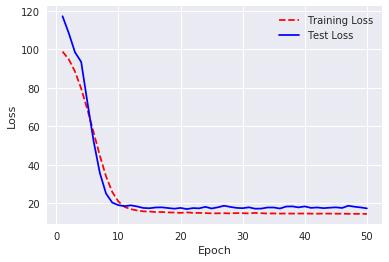

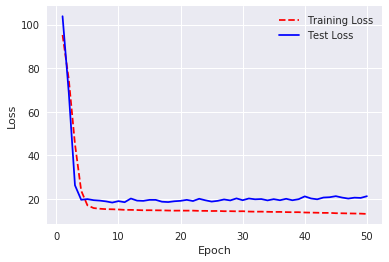

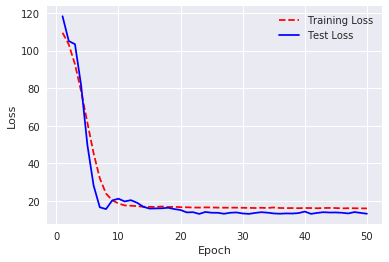

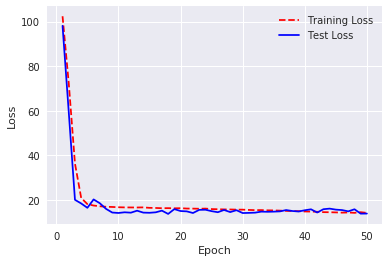

In [281]:
for history in LSTM_time_history:
    # Get training and test loss histories
    training_loss = history.history['mean_absolute_error']
    test_loss = history.history['val_mean_absolute_error']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [271]:
predictions_LSTM = np.concatenate(predictions_LSTM_time)
predictions_train_LSTM = np.concatenate(predictions_train_LSTM_time)

In [272]:
array_train_predictions = []
array_test_predictions = []

for x in df_train.groupby(['dataset_id', 'unit_id']).groups:
    
    df = (df_train.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
    train = df[columns_to_plot].copy()
    
    array_train_predictions_ = [[] for _ in range(len(train))]
    
    for i in range(len(train) - length_sequence + 1):
        for l, k in enumerate(predictions_train_LSTM[i]):
            array_train_predictions_[i+l].append((int(k)))
            
    array_train_predictions.append(array_train_predictions_)
        

for x in df_test.groupby(['dataset_id', 'unit_id']).groups:

    df = (df_test.groupby(['dataset_id', 'unit_id']).get_group(x)).copy()
    test = df[columns_to_plot].copy()

    array_test_predictions_ = [[] for _ in range(len(test))]

    for i in range(len(test) - length_sequence_test + 1):
        for l, k in enumerate(predictions_LSTM[i]):
            array_test_predictions_[i+l].append((int(k)))

    array_test_predictions.append(array_test_predictions_)

In [273]:
predictions_median = []
predictions_train_median = []

for i in range(len(array_train_predictions)):
    for j in array_train_predictions[i]:
        predictions_train_median.append(np.array(j).mean())

for i in range(len(array_test_predictions)):
    for j in array_test_predictions[i]:
        predictions_median.append(np.array(j).mean())


In [274]:
predictions = pd.DataFrame(predictions_median).values
predictions_train = pd.DataFrame(predictions_train_median).values

df_predictions = df_test.join(pd.DataFrame(predictions.round()))
df_predictions_train = df_train.join(pd.DataFrame(predictions_train.round()))

df_predictions.rename(columns={0: 'Prediction'}, inplace=True)
df_predictions_train.rename(columns={0: 'Prediction'}, inplace=True)

In [275]:
df_predictions['error'] = df_predictions.apply(lambda df: error_function(df), axis=1)
df_predictions_train['error'] = df_predictions_train.apply(lambda df: error_function(df), axis=1)

df_predictions['score'] = df_predictions.apply(lambda df: score_function(df), axis=1)
df_predictions_train['score'] = df_predictions_train.apply(lambda df: score_function(df), axis=1)

MSE_all = mean_squared_error(df_predictions['RUL'], df_predictions['Prediction'])
MSE_train_all = mean_squared_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])

print('{:.2f}'.format(MSE_all))
print('{:.2f}'.format(MSE_train_all))

MAE_all = mean_absolute_error(df_predictions['RUL'], df_predictions['Prediction'])
MAE_train_all = mean_absolute_error(df_predictions_train['RUL'], df_predictions_train['Prediction'])

print('{:.2f}'.format(MAE_all))
print('{:.2f}'.format(MAE_train_all))

##################
temp_df = pd.DataFrame(df_predictions.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
df_target = pd.merge(temp_df, df_predictions, how='left', on=('dataset_id', 'unit_id', 'cycle'))

temp_df = pd.DataFrame(df_predictions_train.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
df_target_train = pd.merge(temp_df, df_predictions_train, how='left', on=('dataset_id', 'unit_id', 'cycle'))

MSE = mean_squared_error(df_target['RUL'], df_target['Prediction'])
MSE_train = mean_squared_error(df_target_train['RUL'], df_target_train['Prediction'])

print('{:.2f}'.format(MSE))
print('{:.2f}'.format(MSE_train))

MAE = mean_absolute_error(df_target['RUL'], df_target['Prediction'])
MAE_train = mean_absolute_error(df_target_train['RUL'], df_target_train['Prediction'])

print('{:.2f}'.format(MAE))
print('{:.2f}'.format(MAE_train))

score_test = df_target['score'].sum()
score_train = df_target_train['score'].sum()

print('{:.2f}'.format(score_test))
print('{:.2f}'.format(score_train))

1142.77
2788.30
25.12
36.38
3698.14
12873.79
48.55
97.14
1152537.25
32479134.76


In [276]:
for x in ['FD001', 'FD002', 'FD003', 'FD004']:
    
    df_predictions_temp = df_predictions.loc[df_predictions['dataset_id'] == x].copy()
    df_predictions_train_temp = df_predictions_train.loc[df_predictions_train['dataset_id'] == x].copy()
    
    df_predictions_temp['error'] = df_predictions_temp.apply(lambda df: error_function(df), axis=1)
    df_predictions_train_temp['error'] = df_predictions_train_temp.apply(lambda df: error_function(df), axis=1)

    df_predictions_temp['score'] = df_predictions_temp.apply(lambda df: score_function(df), axis=1)
    df_predictions_train_temp['score'] = df_predictions_train_temp.apply(lambda df: score_function(df), axis=1)
    
    MSE_all = mean_squared_error(df_predictions_temp['RUL'], df_predictions_temp['Prediction'])
    MSE_train_all = mean_squared_error(df_predictions_train_temp['RUL'], df_predictions_train_temp['Prediction'])
    
    print('{:.2f}'.format(MSE_all))
    print('{:.2f}'.format(MSE_train_all))
    
    MAE_all = mean_absolute_error(df_predictions_temp['RUL'], df_predictions_temp['Prediction'])
    MAE_train_all = mean_absolute_error(df_predictions_train_temp['RUL'], df_predictions_train_temp['Prediction'])
    
    print('{:.2f}'.format(MAE_all))
    print('{:.2f}'.format(MAE_train_all))

    ##################
    
    temp_df = pd.DataFrame(df_predictions_temp.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
    df_target = pd.merge(temp_df, df_predictions_temp, how='left', on=('dataset_id', 'unit_id', 'cycle'))

    temp_df = pd.DataFrame(df_predictions_train_temp.groupby(['dataset_id', 'unit_id'])['cycle'].max()).reset_index()
    df_target_train = pd.merge(temp_df, df_predictions_train_temp, how='left', on=('dataset_id', 'unit_id', 'cycle'))
    
    MSE = mean_squared_error(df_target['RUL'], df_target['Prediction'])
    MSE_train = mean_squared_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MSE))
    print('{:.2f}'.format(MSE_train))
    
    MAE = mean_absolute_error(df_target['RUL'], df_target['Prediction'])
    MAE_train = mean_absolute_error(df_target_train['RUL'], df_target_train['Prediction'])
    
    print('{:.2f}'.format(MAE))
    print('{:.2f}'.format(MAE_train))
    
    score_test = df_target['score'].sum()
    score_train = df_target_train['score'].sum()

    print('{:.2f}'.format(score_test))
    print('{:.2f}'.format(score_train))

1088.08
2400.75
23.57
32.17
3613.49
12968.31
46.49
96.81
203396.42
4856095.93
1198.42
2472.13
25.16
32.98
3818.25
12556.00
50.10
94.05
498931.39
12208947.21
1041.43
2786.51
24.48
36.52
3735.78
12750.06
48.02
97.06
168518.12
4276122.12
1155.06
3197.08
25.83
40.72
3591.65
13217.37
47.97
100.53
281691.32
11137969.51


# MLP

In [238]:
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

In [93]:
batch_size = 256
epochs = 3

def model_MLP(train_x, train_y, test_x, test_y, batch_size, epochs, shape):
    model_MLP = Sequential()

    model_MLP.add(Dense(16, input_dim=shape, activation='relu'))
    model_MLP.add(BatchNormalization())
    model_MLP.add(Dropout(0.2))
    model_MLP.add(Dense(4, activation='relu'))
    model_MLP.add(BatchNormalization())
    model_MLP.add(Dropout(0.2))
    model_MLP.add(Dense(1, activation='relu'))

    opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model_MLP.compile(loss='mean_squared_error', optimizer=opt,  metrics=['mae'])

    history = model_MLP.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y), batch_size=batch_size)
    
    return model_MLP, history

MLP_models = []
MLP_history = []

for df in df_train.groupby('dataset_id'):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    columns_to_plot =  sensor_columns
    columns_to_plot = list(np.append(columns_to_plot, ['setting_op_one_hot']))

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    shape = train_x.shape[1]

    train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])
    train_y = train_y.values.reshape(train_y.shape[0], 1)

    test_x = test_x.values.reshape(test_x.shape[0], 1, test_x.shape[1])
    test_y = test_y.values.reshape(test_y.shape[0], 1)
    
    batch_size = 256
    epochs=3
    
    model, history = model_LSTM(train_x, train_y, test_x, test_y, batch_size, epochs, shape)
    
    MLP_models.append(model)
    MLP_history.append(history)


Train on 20631 samples, validate on 13096 samples
Epoch 1/3
20631/20631 [==============================] - 4s 174us/step - loss: 10614.6962 - mean_absolute_error: 91.3801 - val_loss: 13934.1193 - val_mean_absolute_error: 112.8708
Epoch 2/3
20631/20631 [==============================] - 1s 55us/step - loss: 8976.3700 - mean_absolute_error: 84.1957 - val_loss: 11978.1597 - val_mean_absolute_error: 104.4834
Epoch 3/3
20631/20631 [==============================] - 1s 53us/step - loss: 7474.6944 - mean_absolute_error: 76.8314 - val_loss: 10830.0591 - val_mean_absolute_error: 99.2735
Train on 53759 samples, validate on 33991 samples
Epoch 1/3
53759/53759 [==============================] - 6s 103us/step - loss: 9594.1701 - mean_absolute_error: 86.7360 - val_loss: 11661.1447 - val_mean_absolute_error: 102.9168
Epoch 2/3
53759/53759 [==============================] - 3s 54us/step - loss: 6193.1450 - mean_absolute_error: 69.4114 - val_loss: 7456.7928 - val_mean_absolute_error: 81.6136
Epoch 3/3


/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


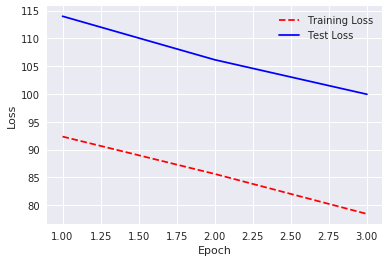

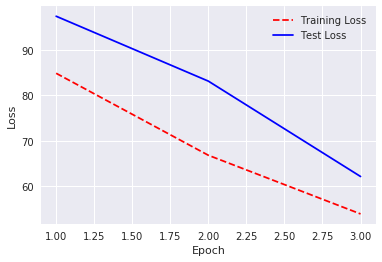

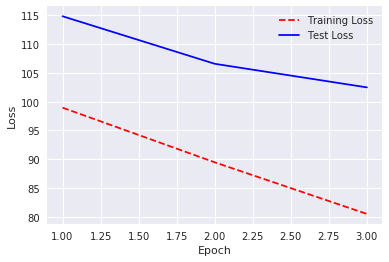

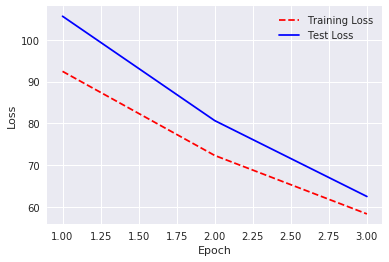

In [213]:
for history in LSTM_history:
    # Get training and test loss histories
    training_loss = history.history['mean_absolute_error']
    test_loss = history.history['val_mean_absolute_error']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [94]:
predictions = []
predictions_train = []
target = []
target_train = []

for df, model in zip(df_train.groupby('dataset_id'), MLP_models):
    
    df_train_temp = df[1]
    df_test_temp = df_test.loc[df_test['dataset_id'] == df[0]]

    columns_to_plot =  sensor_columns
    columns_to_plot = list(np.append(columns_to_plot, ['setting_op_one_hot']))

    train_x = df_train_temp[columns_to_plot].copy()
    train_y = df_train_temp['RUL'].copy()

    test_x = df_test_temp[columns_to_plot].copy()
    test_y = df_test_temp['RUL'].copy()
    
    train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])
    train_y = train_y.values.reshape(train_y.shape[0], 1)

    test_x = test_x.values.reshape(test_x.shape[0], 1, test_x.shape[1])
    test_y = test_y.values.reshape(test_y.shape[0], 1)
    
    df_1, df_2, df_3, df_4 = print_results(model,
                                         df_train_temp,
                                         df_test_temp,
                                         train_x,
                                         test_x,
                                         keras=True)
    predictions.append(df_1)
    predictions_train.append(df_2)
    target.append(df_3)
    target_train.append(df_4)

df_predictions = pd.concat(predictions, ignore_index=True)
df_predictions_train = pd.concat(predictions_train, ignore_index=True)
df_target = pd.concat(target, ignore_index=True)
df_target_train = pd.concat(target_train, ignore_index=True)

df_predictions.reset_index(inplace=True)
df_predictions_train.reset_index(inplace=True)
df_target.reset_index(inplace=True)
df_target_train.reset_index(inplace=True)

10829.45
7812.52
99.27
78.38
4787.73
0.00
61.27
0.00
1026167.28
0.00
4742.95
3369.36
64.14
50.21
2520.71
0.00
42.12
0.00
326584.32
0.00
13122.46
10120.28
110.63
91.03
5429.82
0.00
65.04
0.00
2399146.41
0.00
4296.50
3344.46
61.73
51.43
2511.57
0.00
41.98
0.00
690709.00
0.00


In [95]:
print_results_all(df_predictions, df_predictions_train, df_target, df_target_train)

6653.16
4972.17
74.94
60.59
3249.63
0.00
48.02
0.00
4442607.01
0.00


# PCA

In [237]:
PCA_train = PCA(n_components=3).fit(train_x[columns_to_plot].values)

train_PCA = PCA_train.transform(train_x[columns_to_plot].values)
test_PCA = PCA_train.transform(test_x[columns_to_plot].values)

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


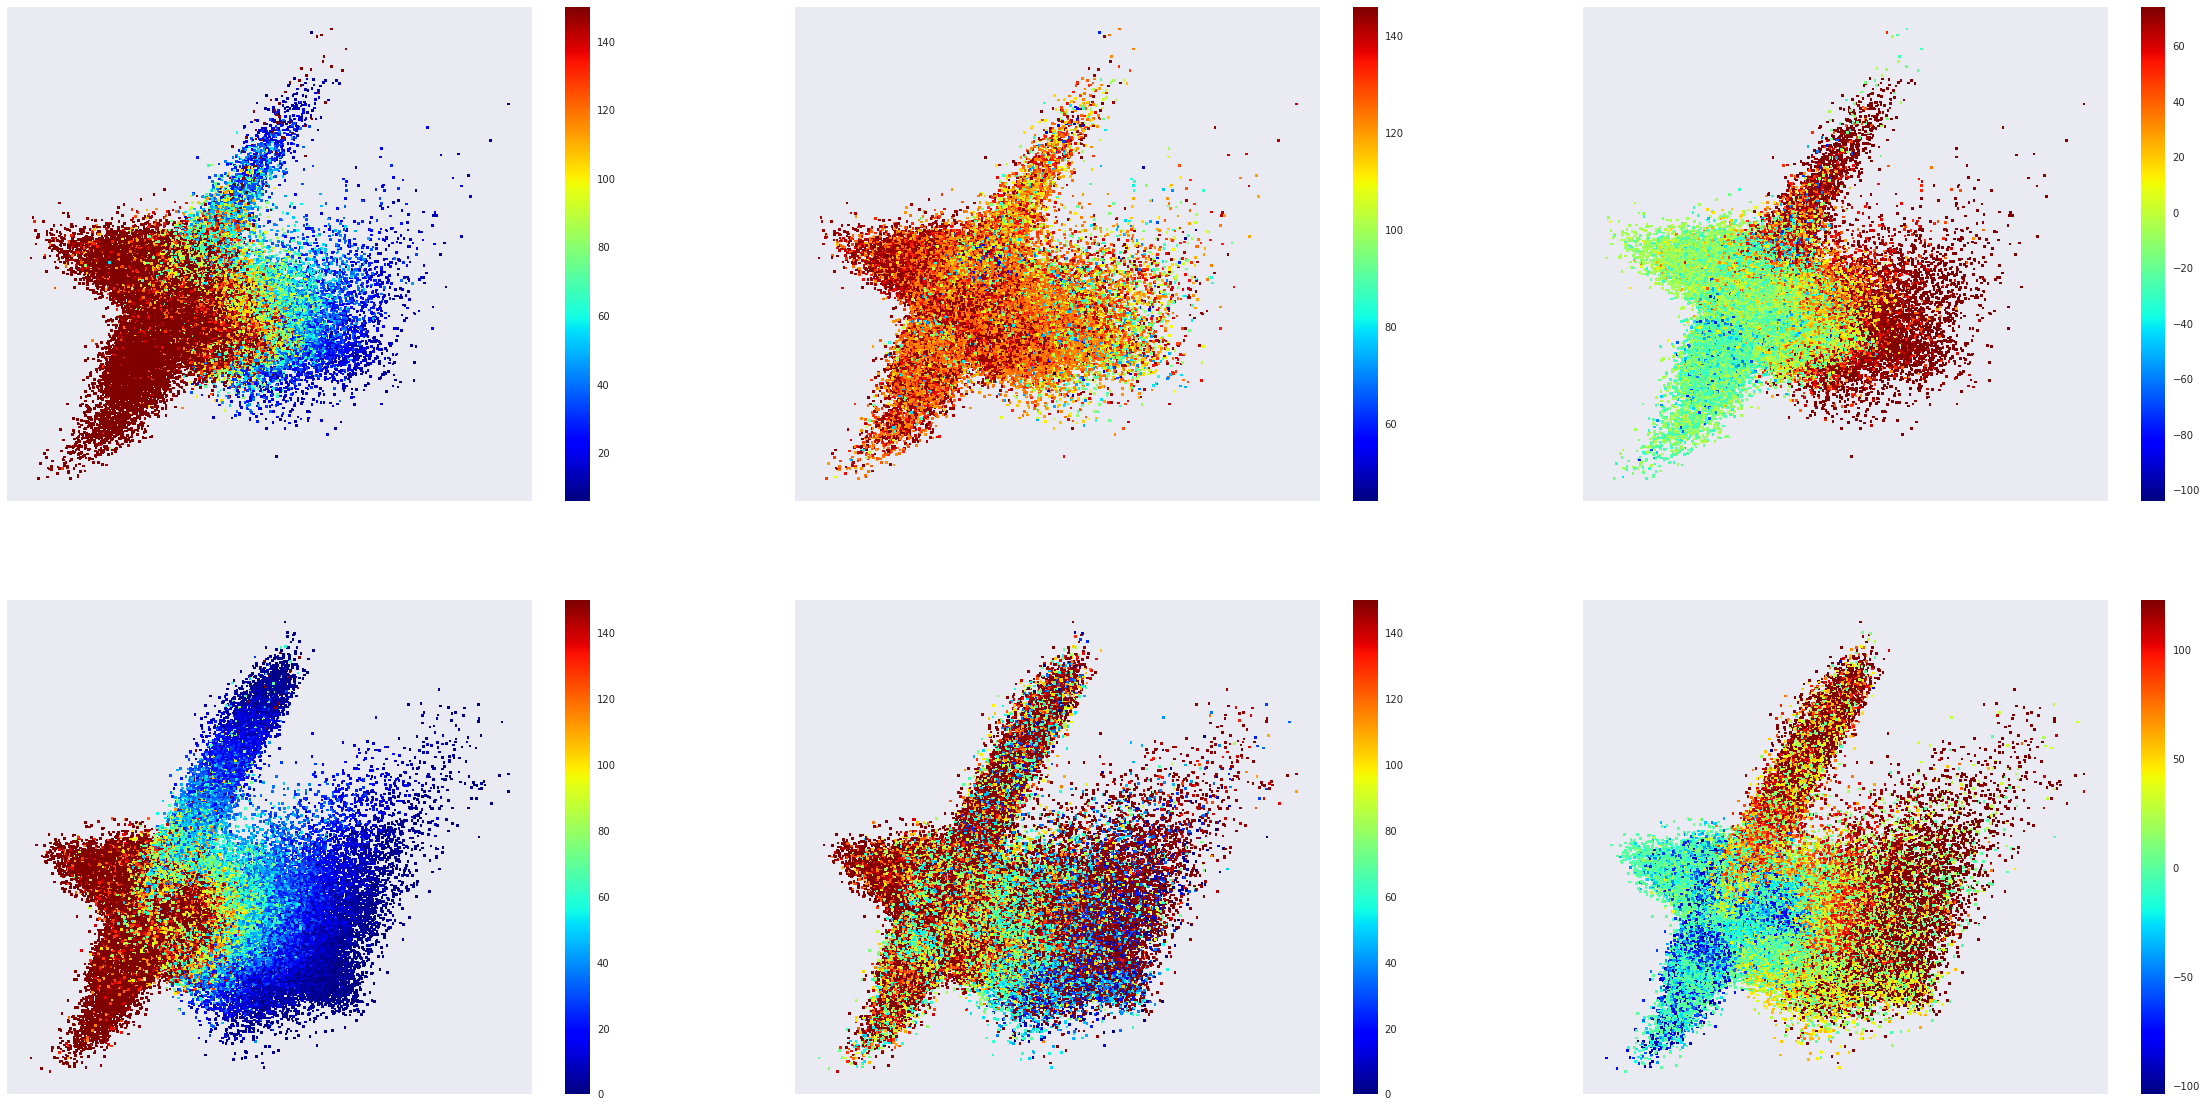

In [282]:
plt.figure(figsize=(40,20))

plt.subplot(2,3,1)
plot_figure(test_PCA, df_test['RUL'])

plt.subplot(2,3,2)
plot_figure(test_PCA, df_predictions['Prediction'].astype(int))

plt.subplot(2,3,3)
plot_figure(test_PCA, df_predictions['error'])

plt.subplot(2,3,4)
plot_figure(train_PCA, df_train['RUL'])

plt.subplot(2,3,5)
plot_figure(train_PCA, df_predictions_train['Prediction'].astype(int))

plt.subplot(2,3,6)
plot_figure(train_PCA, df_predictions_train['error'])

# Regression Visualization

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


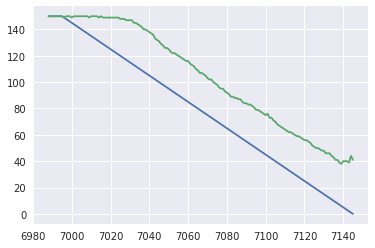

In [278]:
df_predictions_train[(df_predictions_train.dataset_id == 'FD001') & (df_predictions_train.unit_id == 36)]['RUL'].plot()
df_predictions_train[(df_predictions_train.dataset_id == 'FD001') & (df_predictions_train.unit_id == 36)]['Prediction'].plot()
#df_predictions_train[(df_predictions_train.dataset_id == 'FD002') & (df_predictions_train.unit_id == 1)]['error'].plot()

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


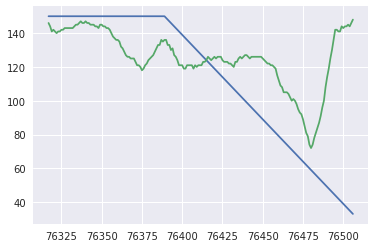

In [279]:
df_predictions[(df_predictions.dataset_id == 'FD004') & (df_predictions.unit_id == 70)]['RUL'].plot()
df_predictions[(df_predictions.dataset_id == 'FD004') & (df_predictions.unit_id == 70)]['Prediction'].plot()
#df_predictions[(df_predictions.dataset_id == 'FD004') & (df_predictions.unit_id == 70)]['score'].plot()

# UMAP

In [66]:
UMAP_Train = umap.UMAP().fit_transform(train_x.values)
UMAP_Test = umap.UMAP().fit_transform(test_x.values)

/home/rneves/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


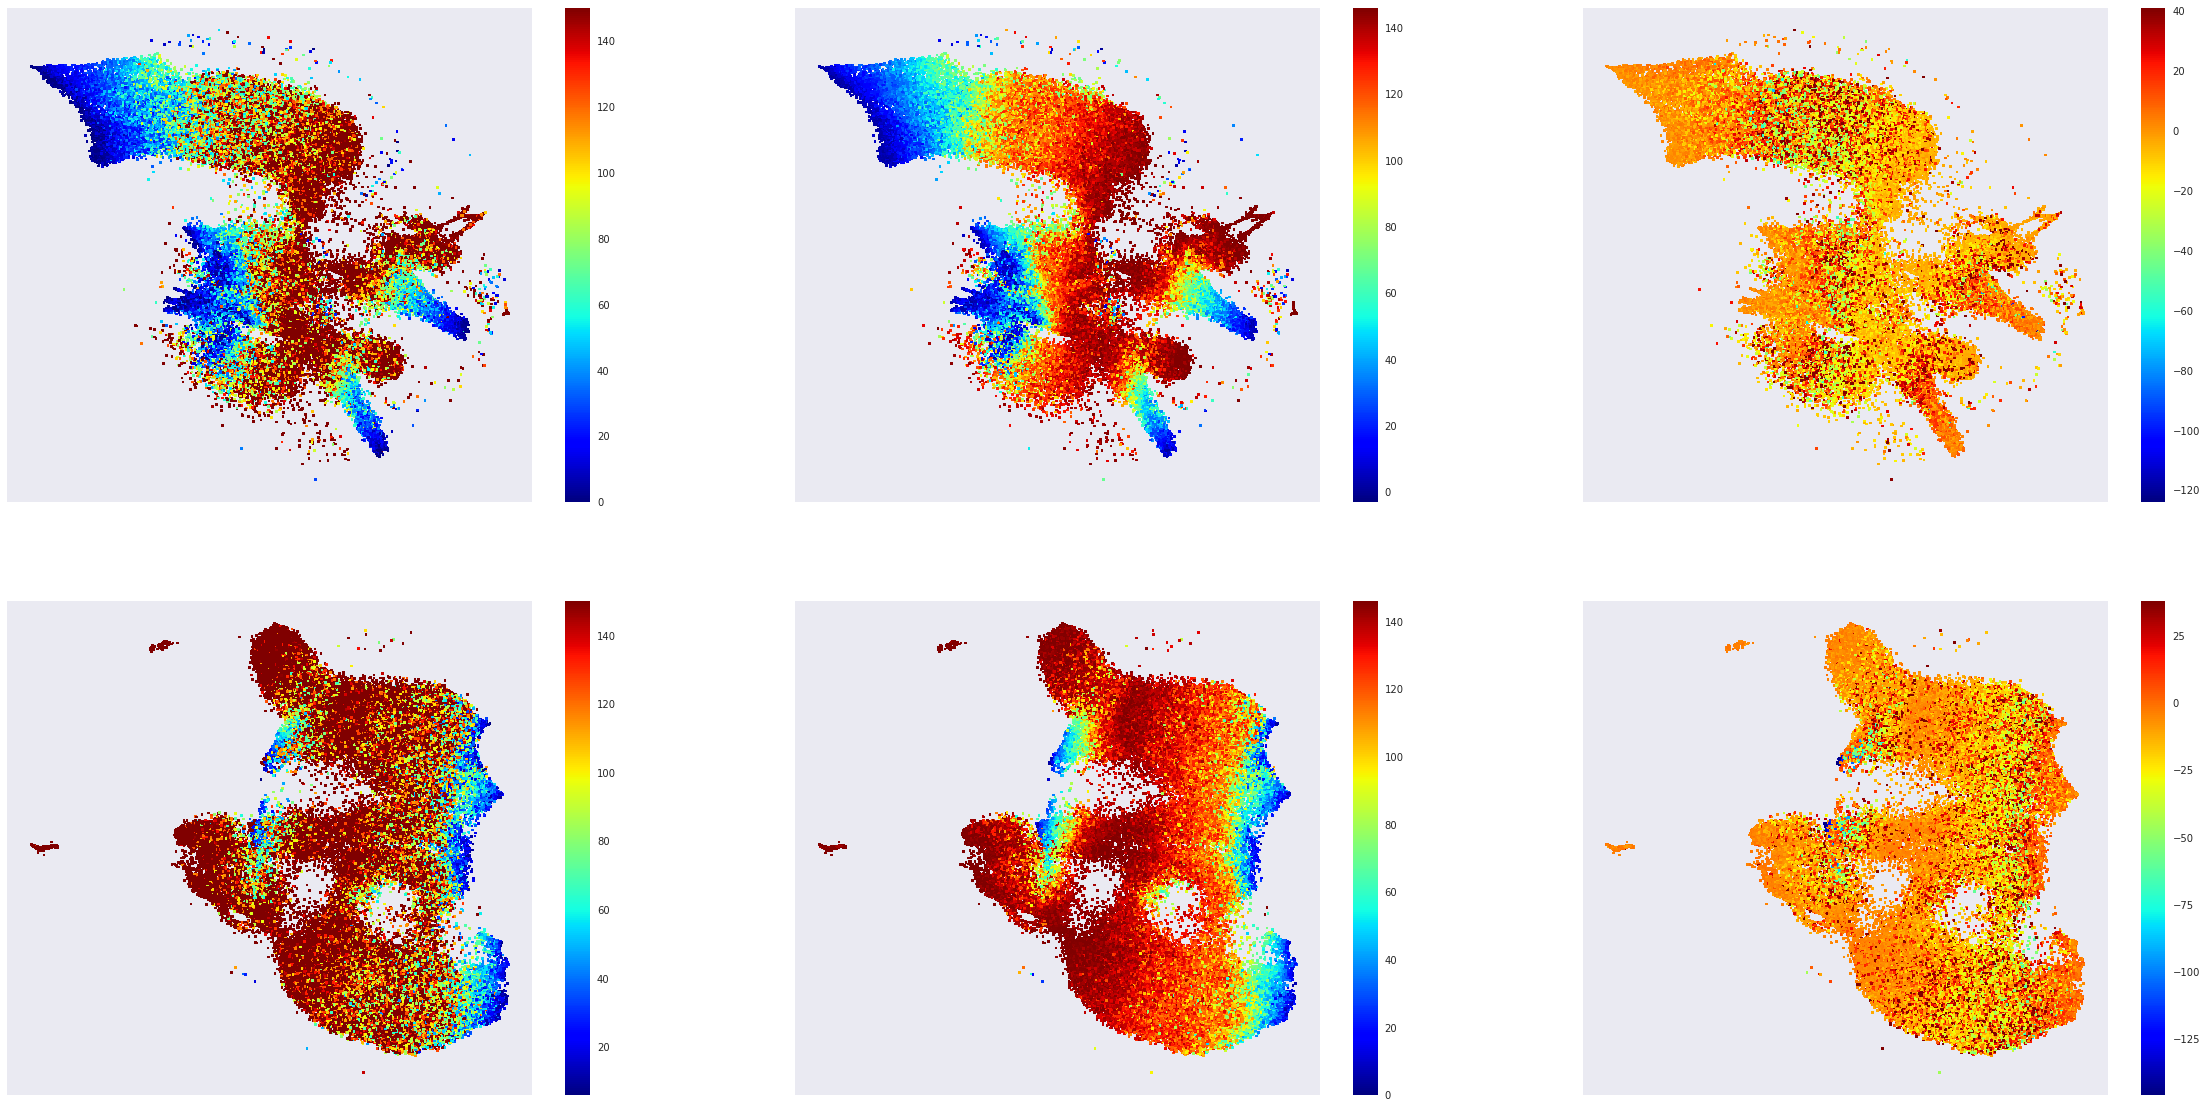

In [67]:
plt.figure(figsize=(40,20))

plt.subplot(2,3,1)
plot_figure(UMAP_Train, df_predictions_train['RUL'])


plt.subplot(2,3,2)
plot_figure(UMAP_Train, df_predictions_train['Prediction'])


plt.subplot(2,3,3)
plot_figure(UMAP_Train, df_predictions_train['error'])


plt.subplot(2,3,4)
plot_figure(UMAP_Test, df_predictions['RUL'])


plt.subplot(2,3,5)
plot_figure(UMAP_Test, df_predictions['Prediction'])


plt.subplot(2,3,6)
plot_figure(UMAP_Test, df_predictions['error'])
